# Compute event metrics


In [5]:
# copy & modify AVO code to plot eventrate & energy rate & eventually sausage plot
# process events
import os, sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import obspy
from datetime import datetime
localLibPath = Path.cwd().resolve().parents[0].joinpath('lib')
sys.path.append(str(localLibPath))
EVENTS_DIR = Path.cwd().parents[1].joinpath('data','events')
CATALOG_DIR = Path.cwd().parents[1].joinpath('data','catalogs')
RESPONSE_DIR = Path.cwd().parents[1].joinpath('data','responses')
from SAM import VSAM, DSAM
import tools

def compute_metrics(st, evtime, duration, show_response_plots=False, show_stream_plots=False, show_frequency_plots=False, interactive=False, return_dominantF=False):
    for tr in st:
        tr.stats['units'] = 'Counts'
    st.detrend('linear')
    #st.taper(0.05, type='hann')
    if show_stream_plots:
        st.plot();
    
    # load instrument response, remove instrument response from seismogramobspy.core.event.read_events
    stationxml = os.path.join(RESPONSE_DIR, 'MV.xml')
    inv = obspy.read_inventory(stationxml)
    
    # remove instrument response - and set units accordingly IMPORTANT!
    pre_filt = [0.25, 0.5, 25, 50]
    
    vel = st.copy()
    vel.remove_response(inventory=inv, pre_filt=pre_filt, output="VEL", plot=show_response_plots) 
    for tr in vel:
        tr.stats['units'] = 'm/s'
    if show_stream_plots:
        vel.plot();
    vel.trim(starttime=evtime, endtime=evtime+duration)
    
    disp = st.copy()
    disp.remove_response(inventory=inv, pre_filt=pre_filt, output="DISP", plot=show_response_plots) 
    for tr in disp:
        tr.stats['units'] = 'm'
    if show_stream_plots:
        disp.plot();
    disp.trim(starttime=evtime, endtime=evtime+duration)

    # Generate a Velocity Seismic Amplitude Measurement (VSAM) object - units must be 'm/s' else will not work
    vsamObj = VSAM(stream=vel, sampling_interval=2.56)
    #print(vsamObj)  
    if show_frequency_plots:
        try:
            vsamObj.plot(metrics=['fratio'])
        except:
            if interactive:
                input('<ENTER> to continue')    
            return None

    if return_dominantF:
        # Generate a Displacement Seismic Amplitude Measurement (DSAM) object - units must be 'm' else will not work
        dsamObj = DSAM(stream=disp, sampling_interval=2.56)
        #print(dsamObj)
        #dsamObj.plot()
    
        N = len(st)
        vsam_stream = vsamObj.to_stream()
        dsam_stream = dsamObj.to_stream()
        dfdom = pd.DataFrame()
        dfdom['datetime'] = [t.datetime for t in vsam_stream[0].times('utcdatetime')]
        for c in range(N):
            fdominant = np.divide(np.absolute(vsam_stream[c].data), np.absolute(dsam_stream[c].data)) / (2 * np.pi)
            dfdom[vsam_stream[c].id] = fdominant
        if show_frequency_plots:
            dfdom.plot(x='datetime', ylabel='Dominant Frequency (Hz)')
        dfdom['mean'] = dfdom.mean(axis=1, numeric_only=True)
    else:
        dfdom = None

    dfratio = pd.DataFrame()
    for i, seed_id in enumerate(vsamObj.dataframes):
        df = vsamObj.dataframes[seed_id]
        #print(df.columns)
        if i==0:
            dfratio['datetime'] = [obspy.core.UTCDateTime(t).datetime for t in df['time']]
        dfratio[seed_id] = df['fratio']
    dfratio['mean'] = dfratio.mean(axis=1, numeric_only=True)
    #print(dfratio)
    
    if interactive:
        input('<ENTER> to continue')
    return dfdom, dfratio

def classify_event(dfdom, dfratio):
    # plot fratio and dfdomfor index, row in df.iterrows():
    '''
    fig = plt.figure()
    ax1 = fig.add_subplot(2,1,1)
    dfdom.plot(ax=ax1, x='datetime', y='mean')
    ax1.set_title('Dominant Frequency (Hz)')
    ax2 = fig.add_subplot(2,1,2)
    dfratio.plot(ax=ax2, x='datetime', y='mean')   
    ax2.set_title('Frequency Ratio')
    plt.show()
    '''
    m = dfratio['mean'].mean()
    if m > -0.5:
        subclass = 'VT'
    elif m < -0.5:
        subclass = 'LP'
    if m > -1.0 and m < 0.0 and dfratio.iloc[0:2]['mean'].mean() > dfratio.iloc[-2:]['mean'].mean() + 1.0:
        subclass = 'Hybrid'

In [2]:
os.listdir(EVENTS_DIR)

['catalog.pkl', 'REA', 'WAV']

In [6]:
# load catalog
pklfile = os.path.join(CATALOG_DIR,'catalog.pkl')
qmlfile = os.path.join(CATALOG_DIR,'catalog.xml')
catDF, catObj = tools.load_catalog(pklfile, qmlfile)
print(catDF)
print(catObj)

Loading /superfast2TB/home2/thompsong/Developer/skience2024heiner/VolcanoSeismicMonitoring/data/catalogs/catalog.pkl
                      datetime  magnitude         energy latitude longitude  \
0   2003-07-11 23:40:24.226667   3.136026   50587.073176     None      None   
1   2003-07-11 23:41:04.400000   3.178833   58647.584698     None      None   
2   2003-07-11 23:41:42.280000   3.211300   65606.879706     None      None   
3   2003-07-11 23:42:19.813333   3.190350   61027.463468     None      None   
4   2003-07-11 23:42:58.626667   3.146574   52464.004959     None      None   
..                         ...        ...            ...      ...       ...   
906 2003-07-16 04:28:09.293334   2.837668   18051.010130     None      None   
907 2003-07-16 04:42:07.413333   2.871079   20259.050921     None      None   
908 2003-07-16 04:44:36.200000   2.905099   22784.978811     None      None   
909 2003-07-16 05:09:45.626667   3.506343  181766.497358     None      None   
910 2003-07-16

2003-07-11T23:40:24.226667Z


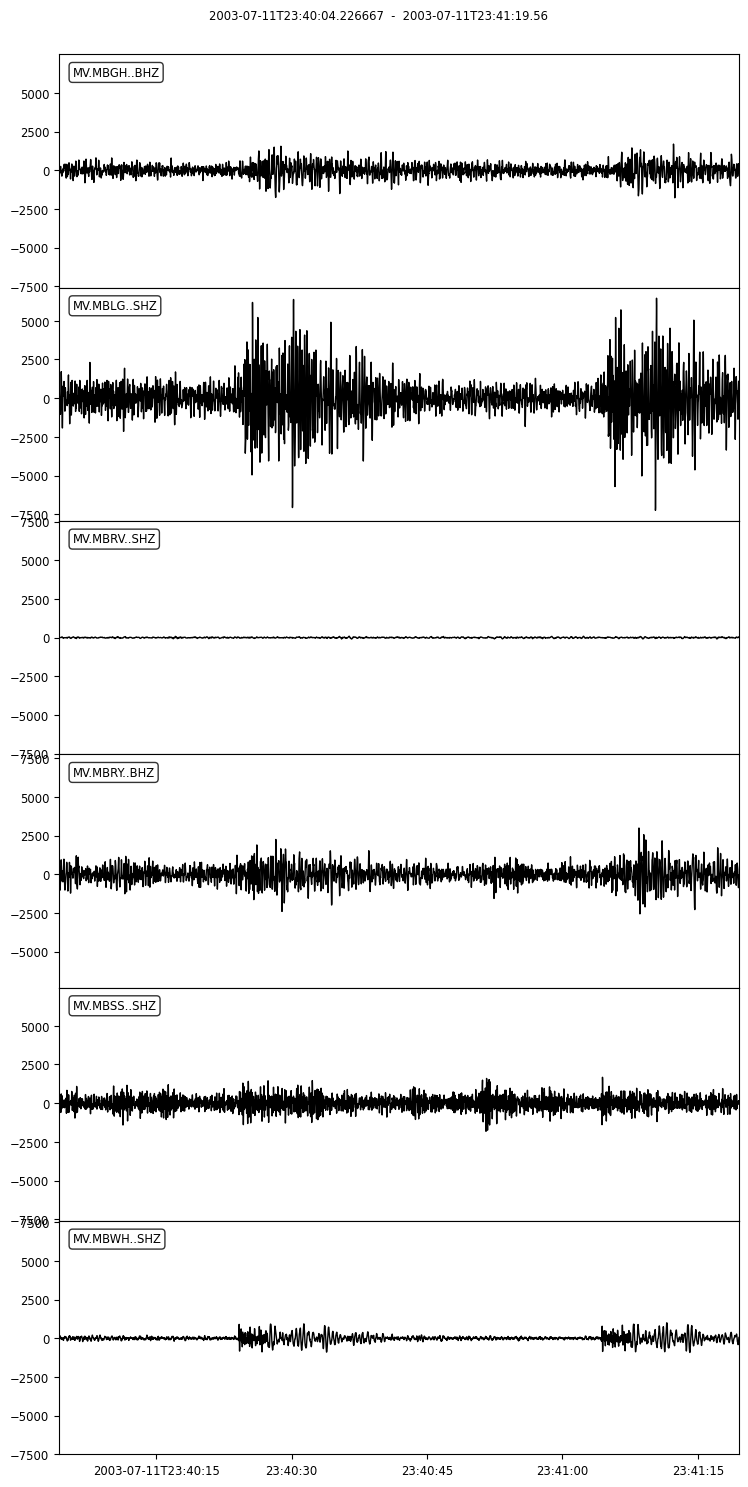

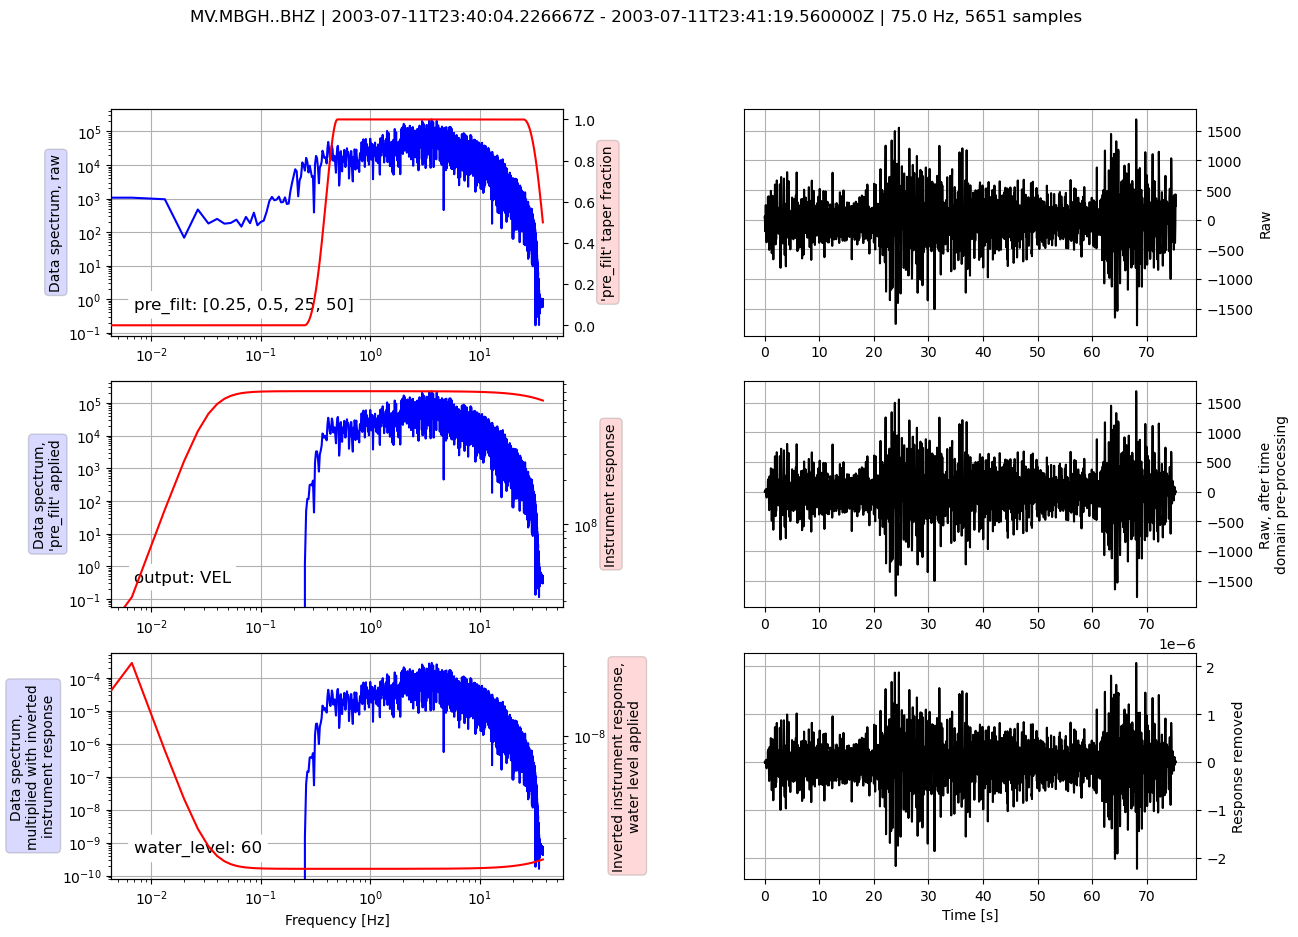

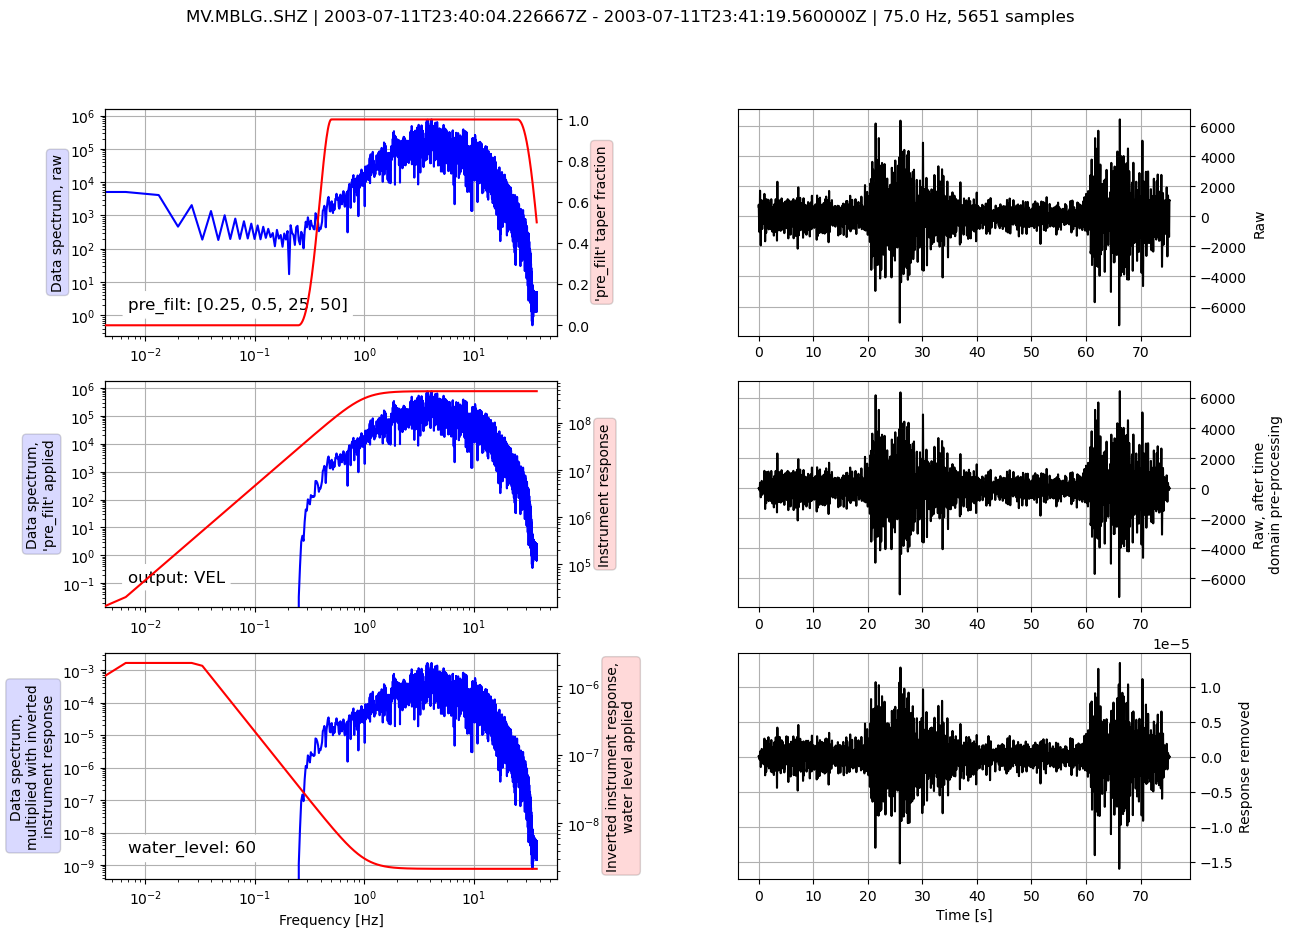

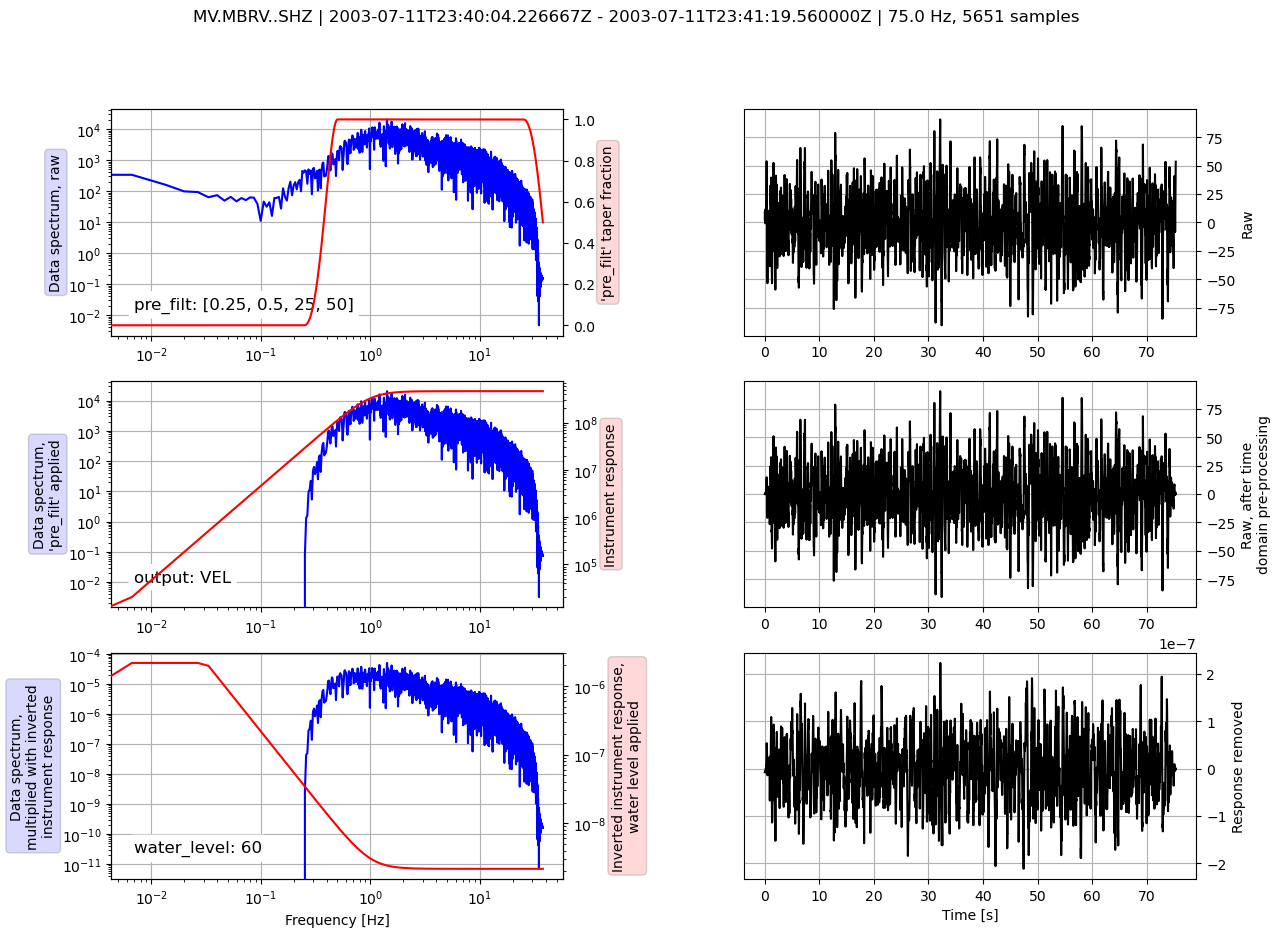

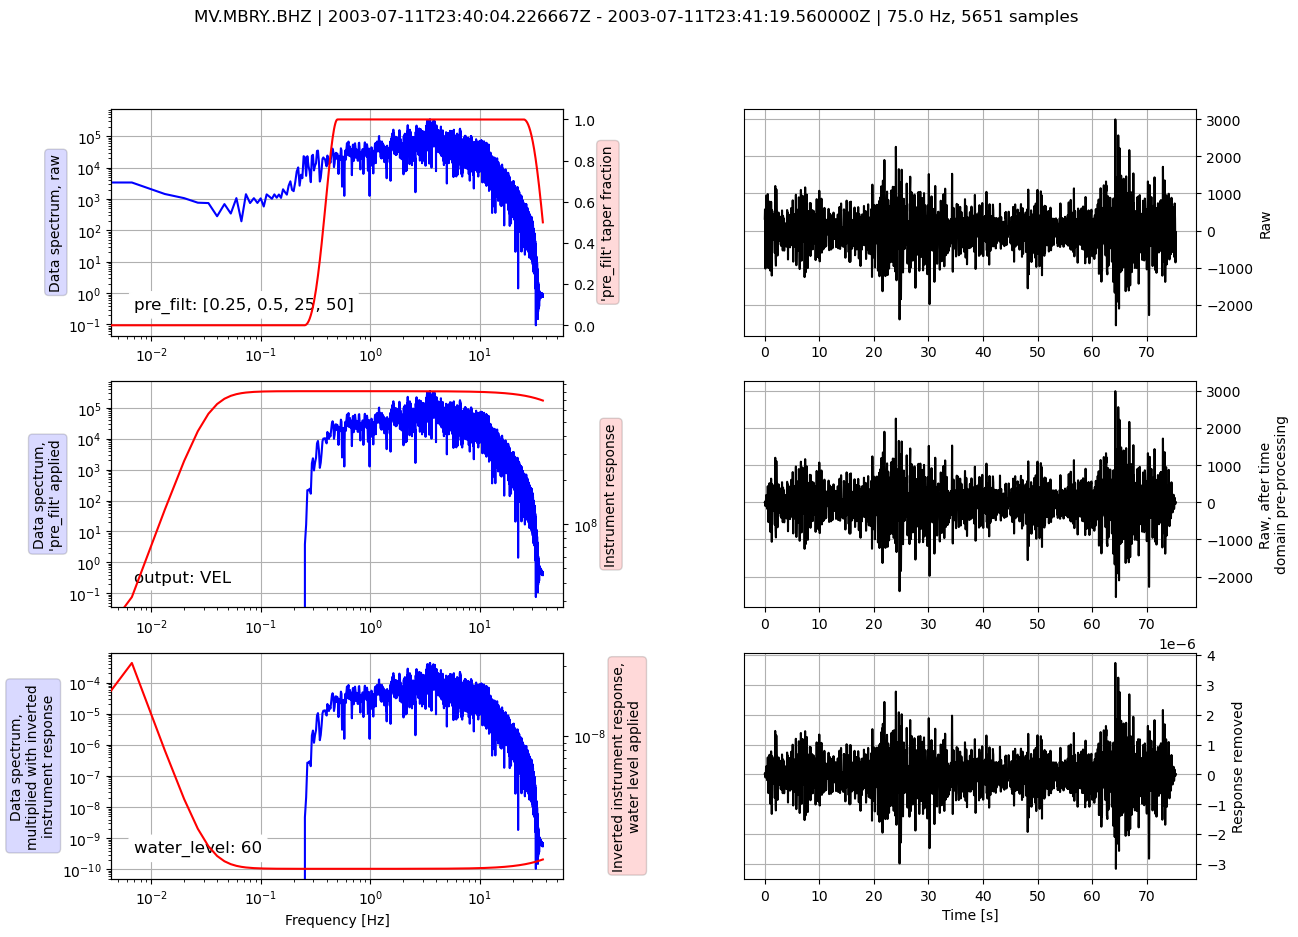

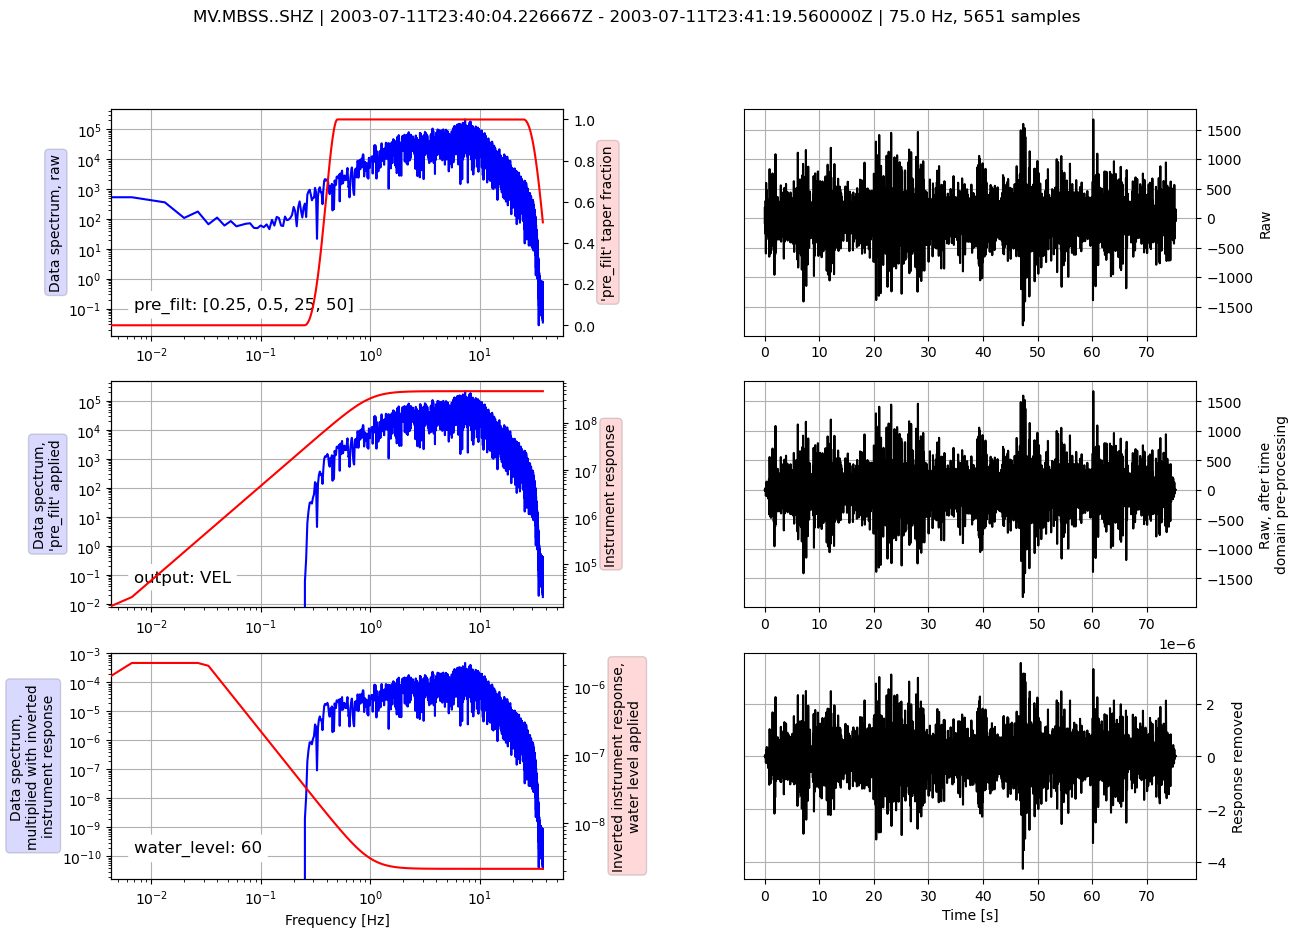

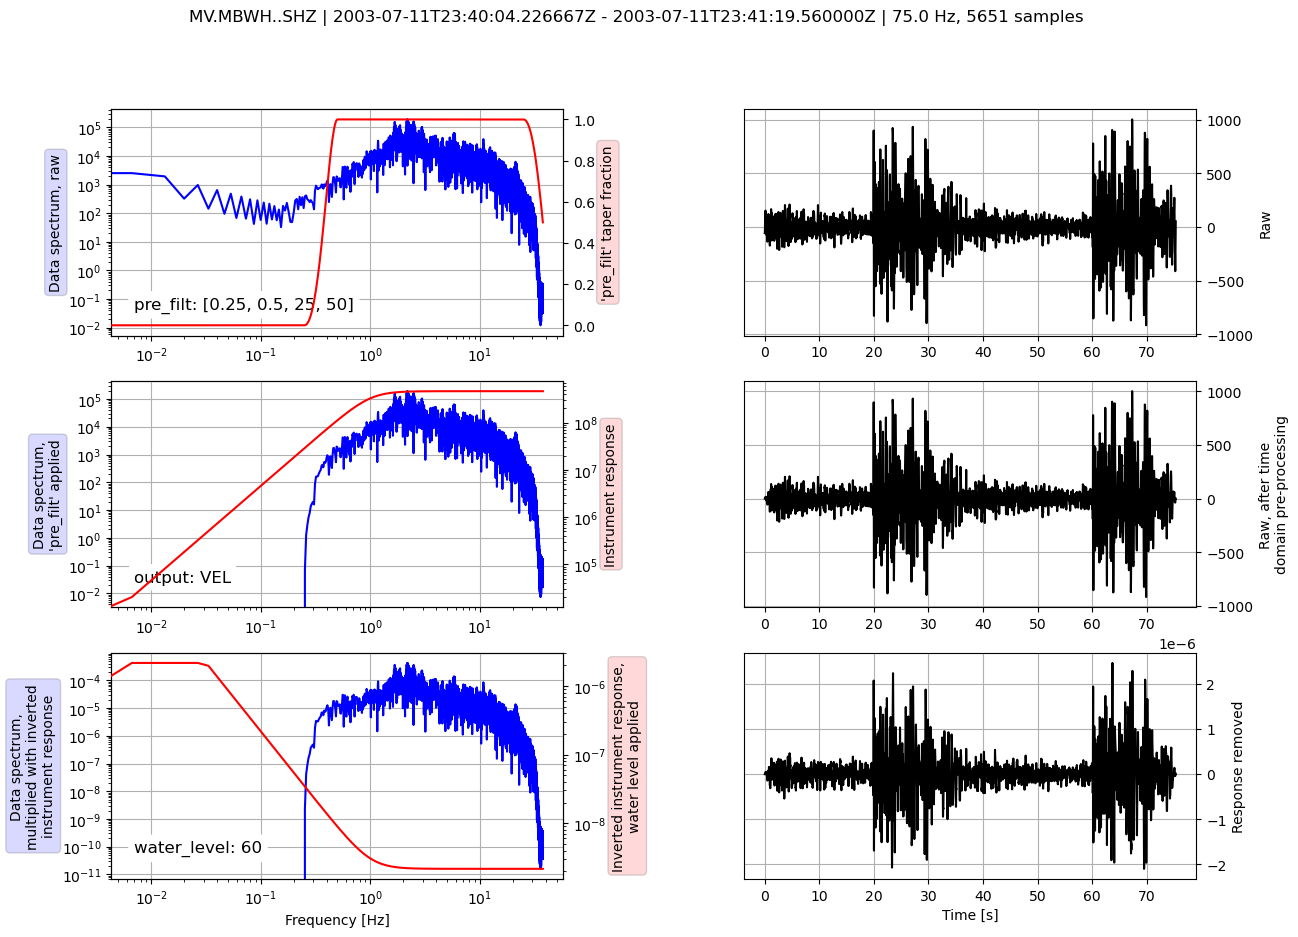

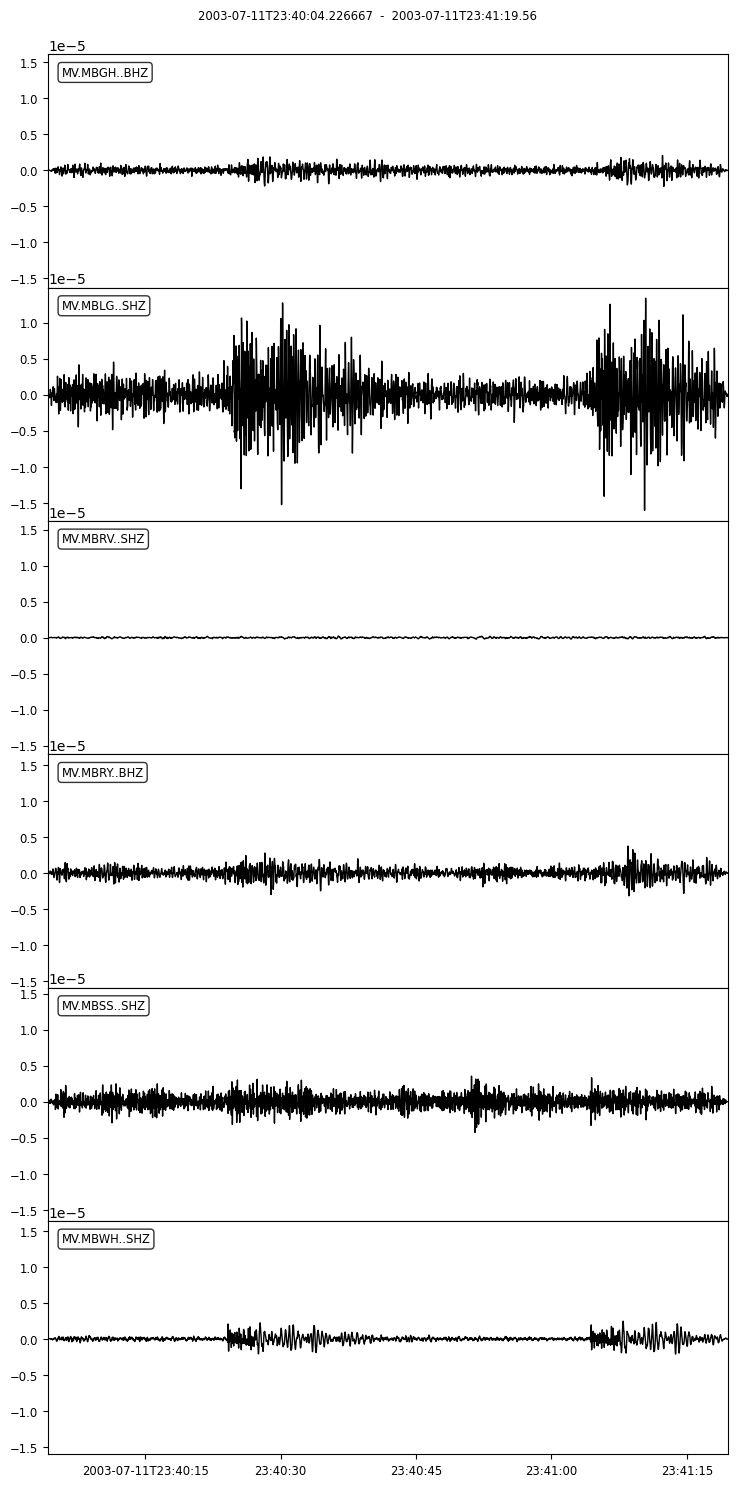

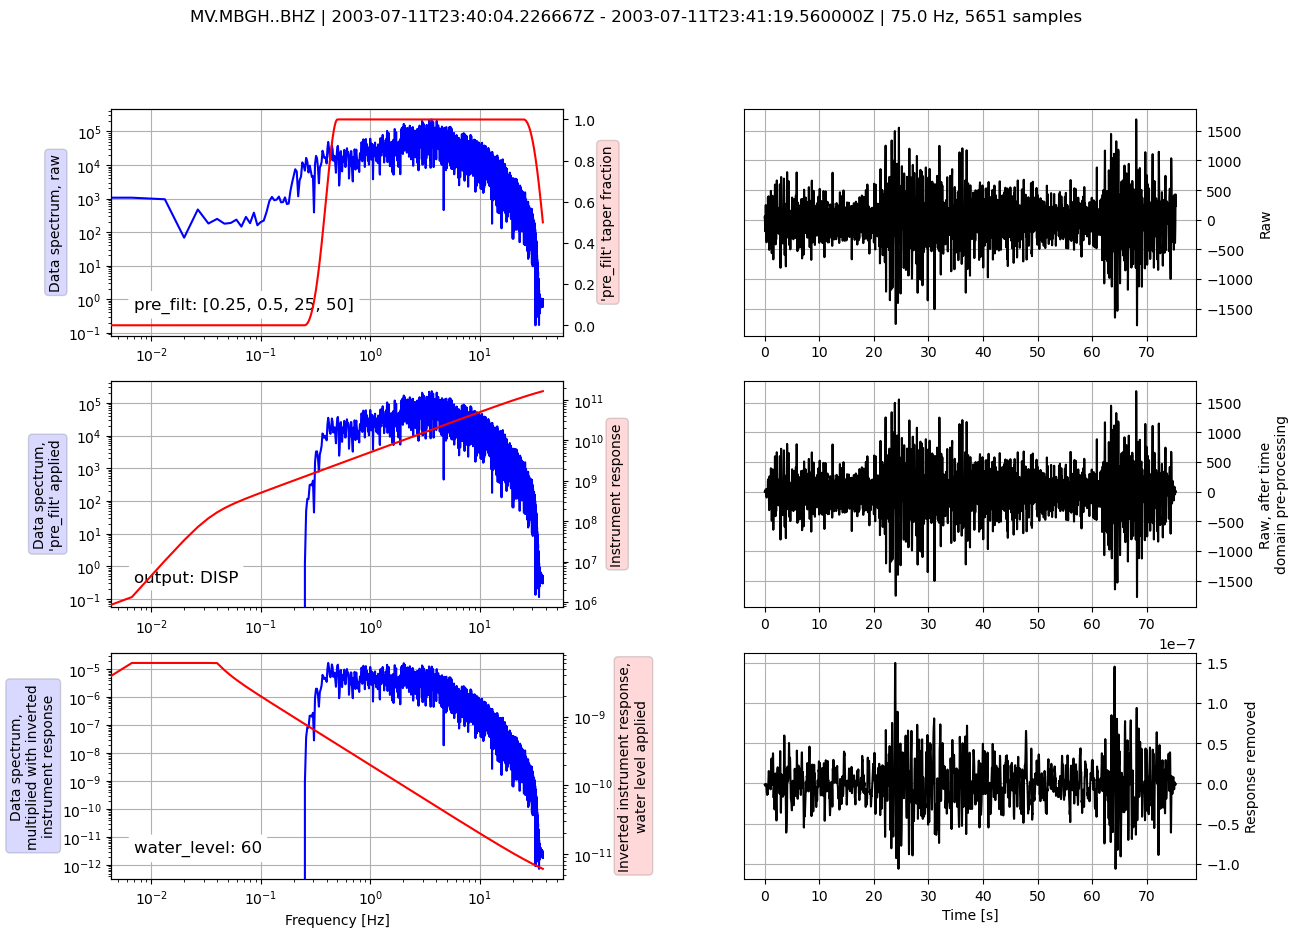

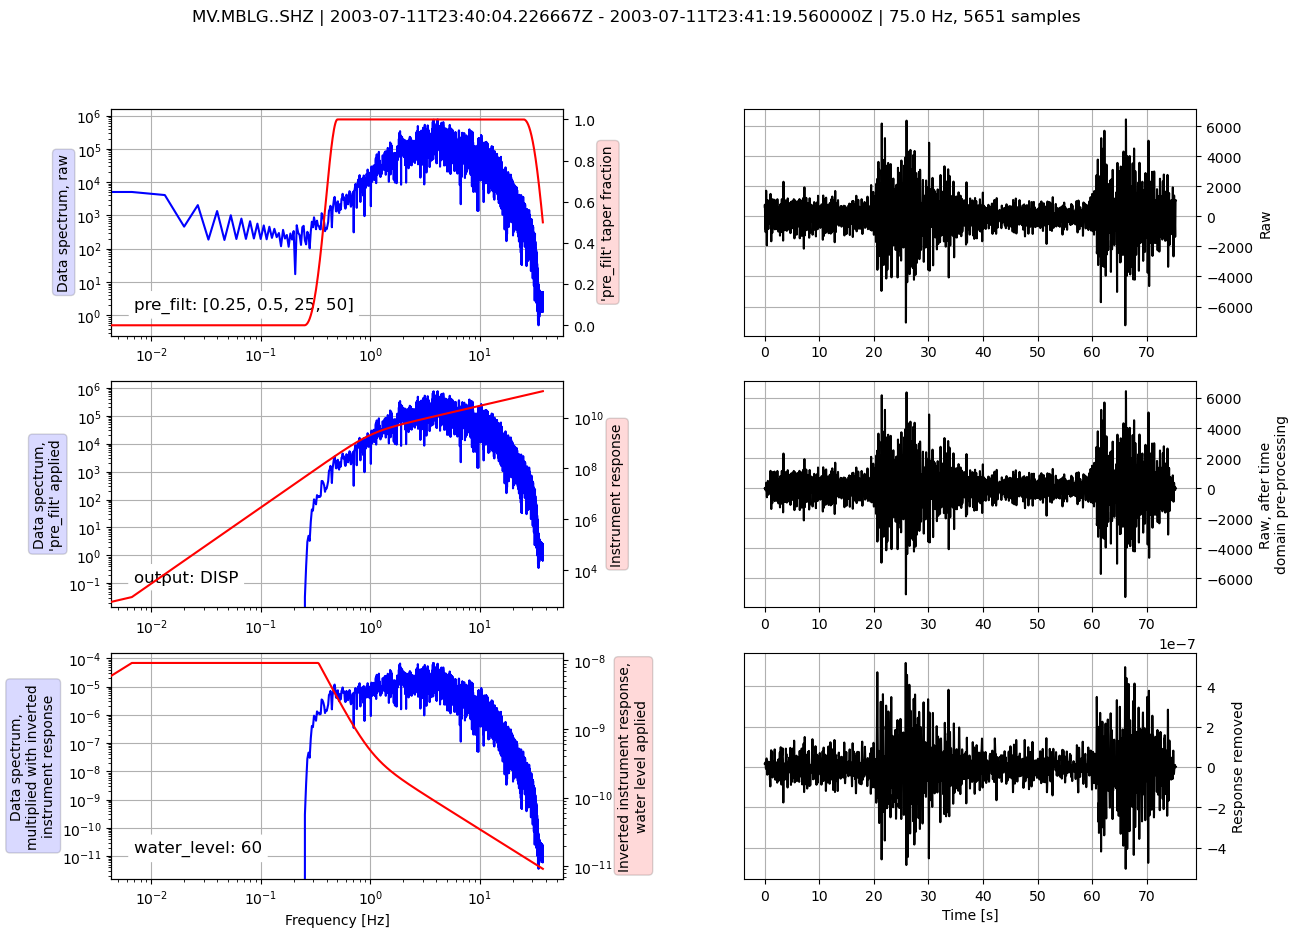

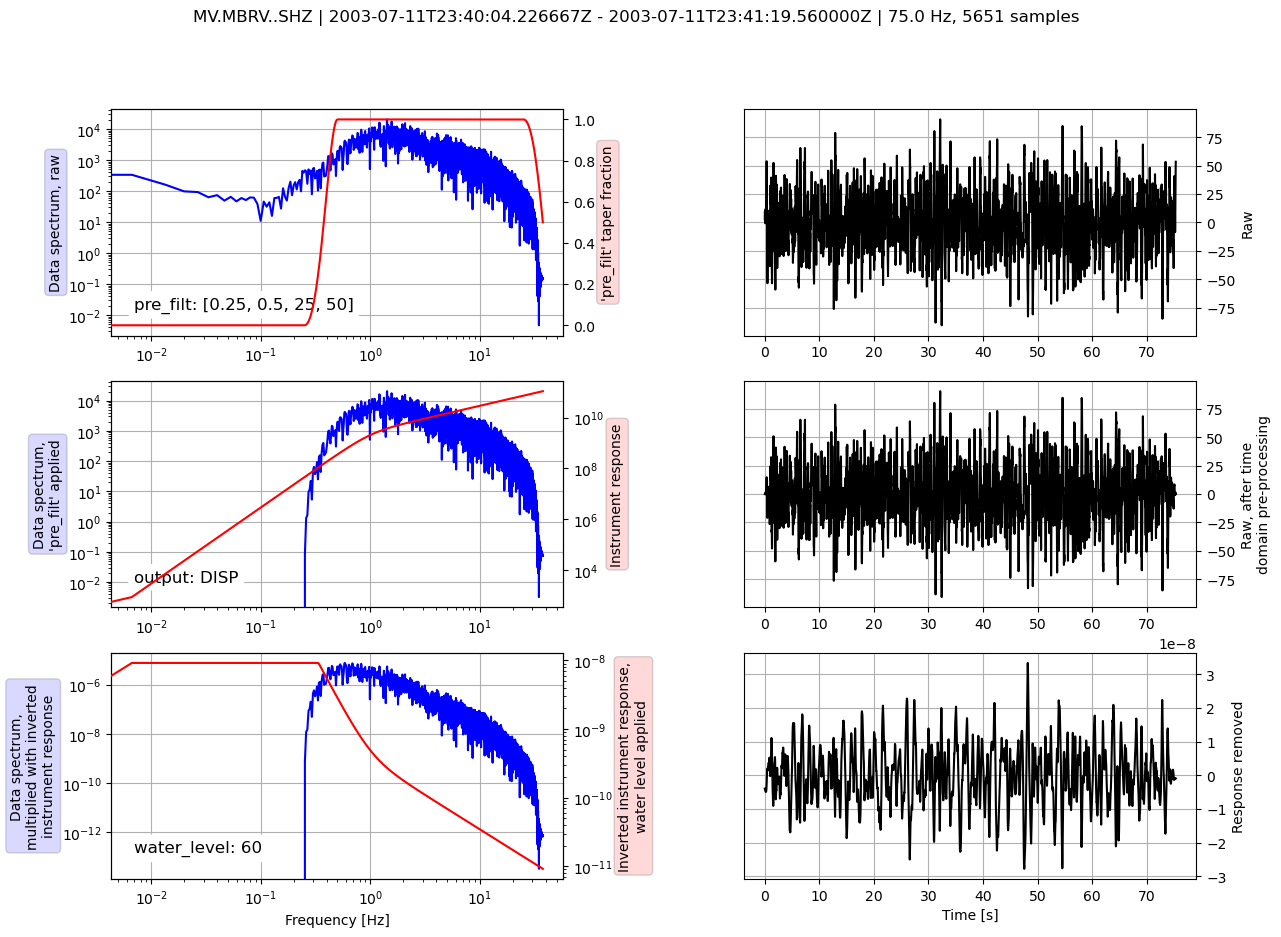

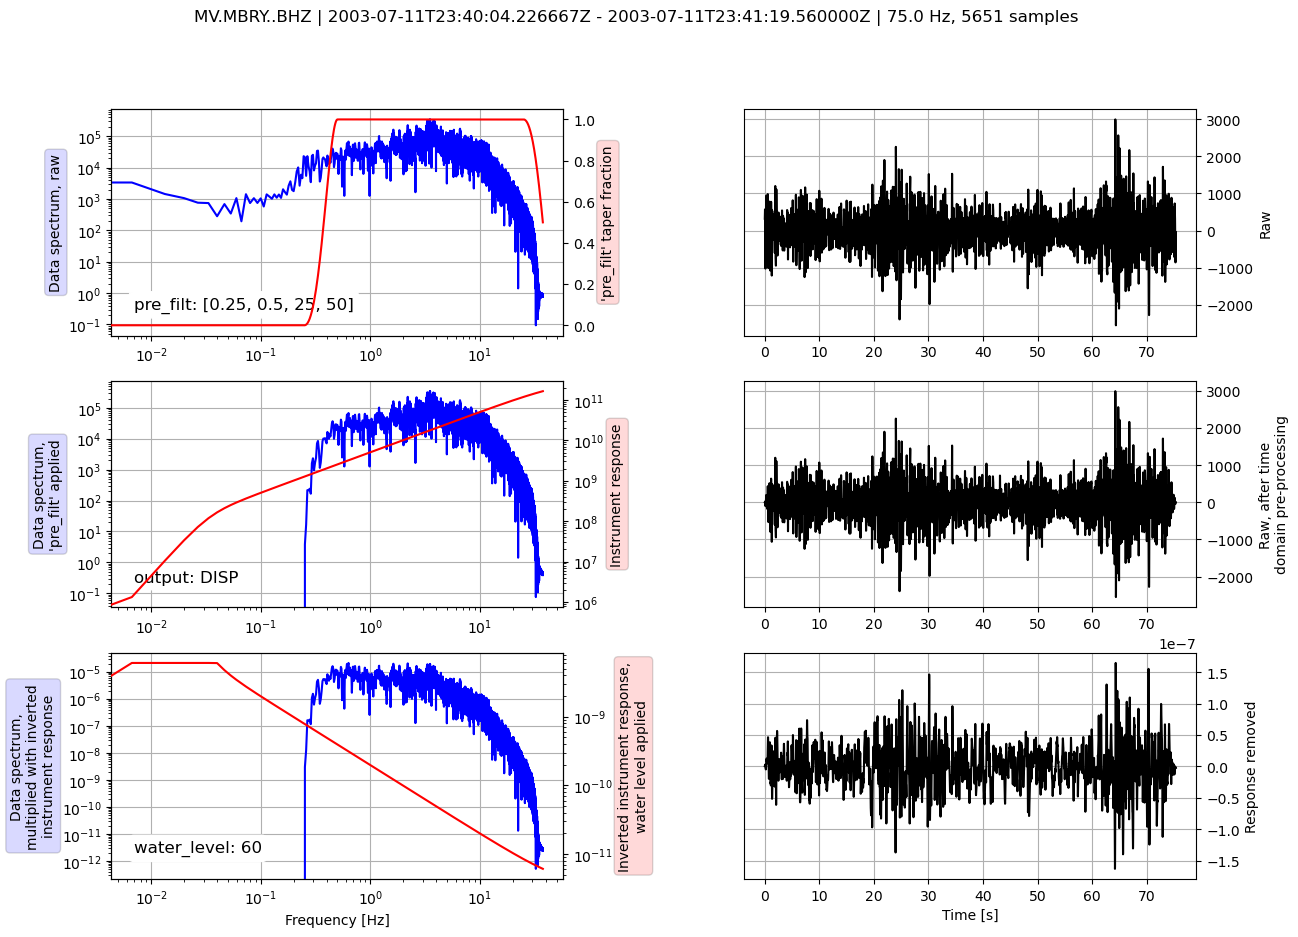

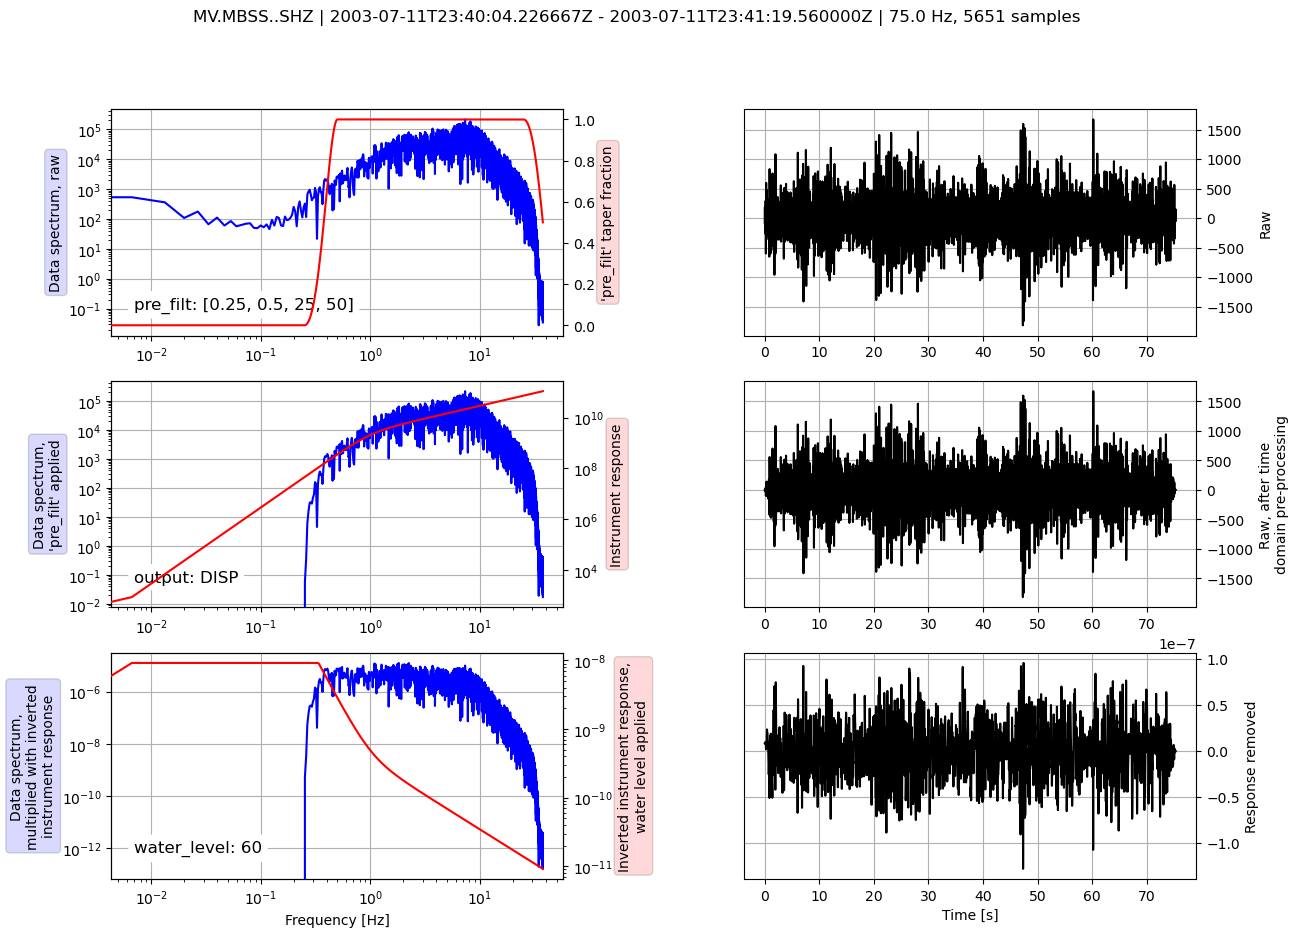

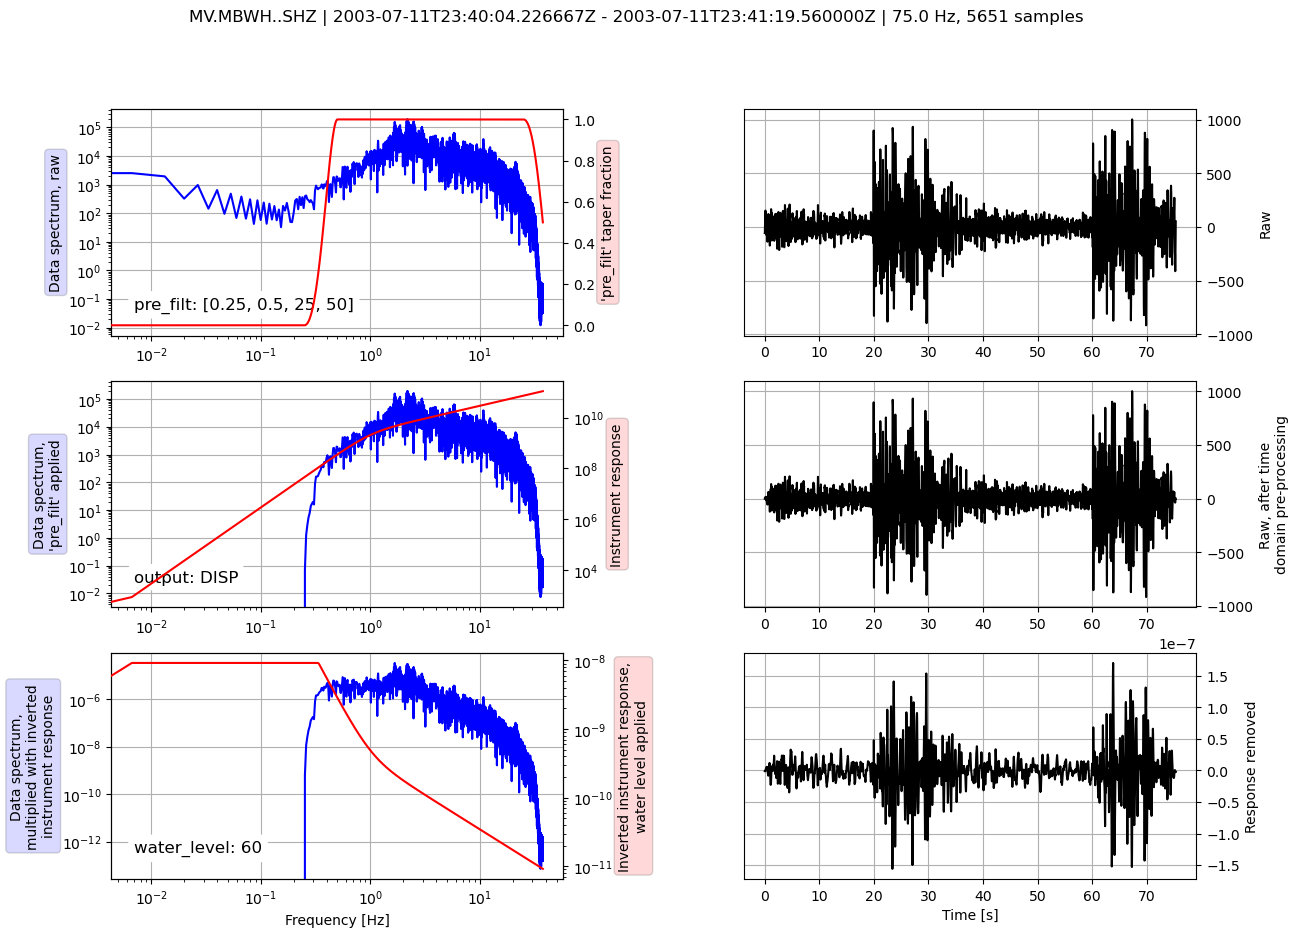

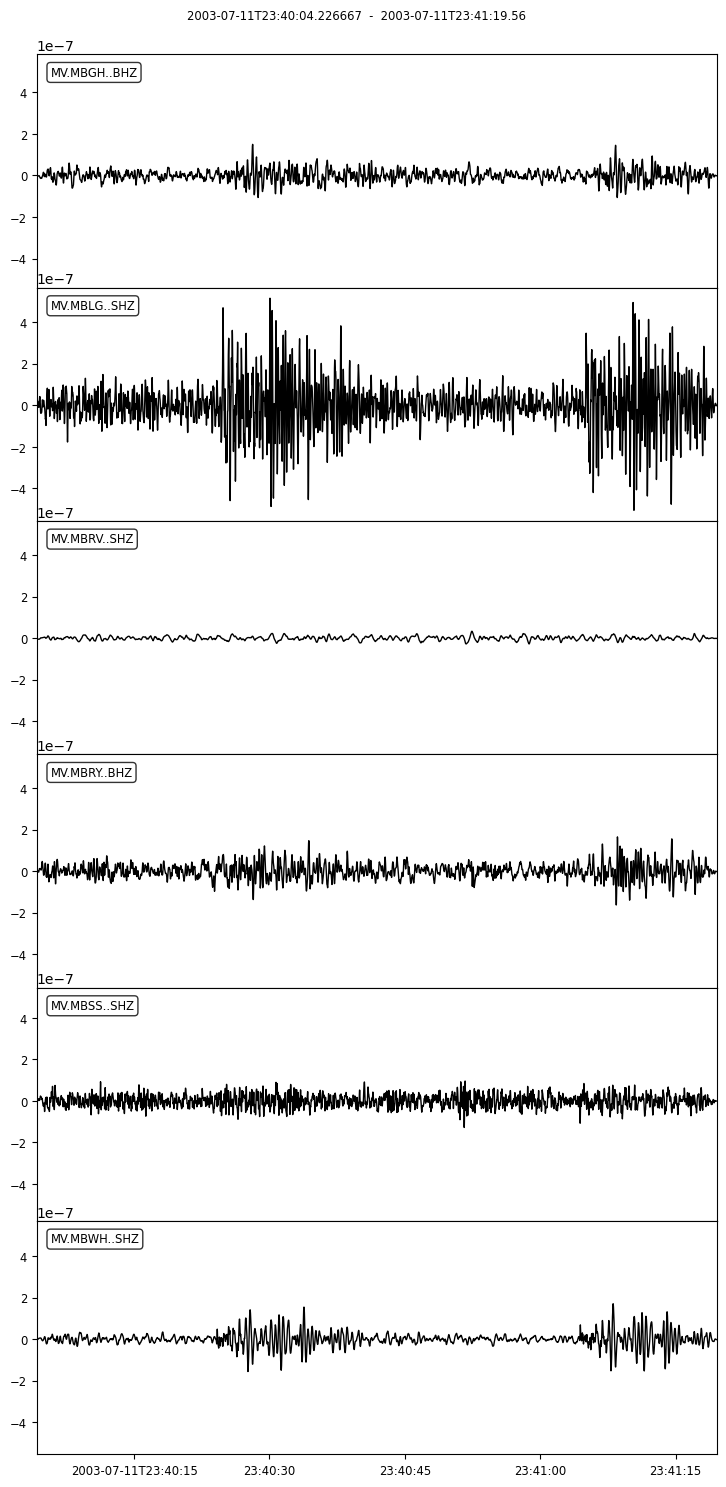

METRIC:  fratio


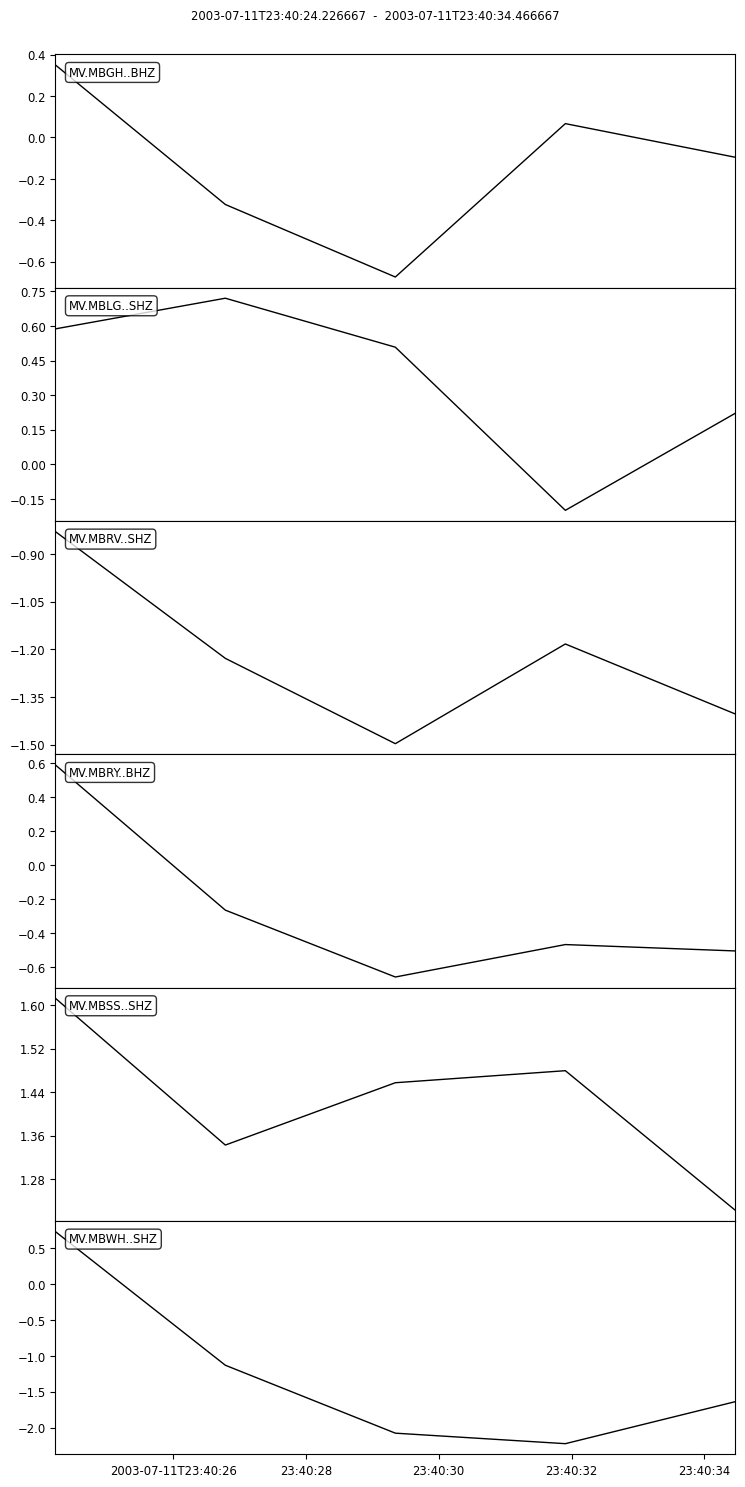

Dominant frequency for whole event: 3.1 Hz


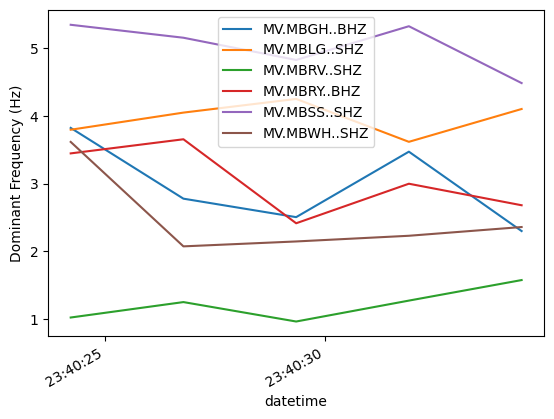

In [9]:
# examine 1 event
row = catDF.iloc[0]
evtime = obspy.UTCDateTime(row['datetime'])
print(evtime)
year = evtime.strftime('%Y')
month = evtime.strftime('%m')
duration = row['durations']
mseedfile = os.path.join(EVENTS_DIR, 'WAV', 'MV', year, month, row['filename'] + '.mseed')
st = obspy.read(mseedfile, 'MSEED')
dfdom, dfratio = compute_metrics(st, evtime, duration, show_response_plots=True, show_stream_plots=True, show_frequency_plots=True, return_dominantF=True)

print(f"Dominant frequency for whole event: {dfdom['mean'].mean():.1f} Hz")

In [14]:
# process events
subclasses = []
dfratio_all = None
max_i = 999
catDF['subclass'] = None
for index, row in catDF.iterrows():
    #print(index, row)
    if index>max_i:
        continue
    evtime = obspy.UTCDateTime(row['datetime'])
    print(evtime)
    duration = row['durations']
    year = evtime.strftime('%Y')
    month = evtime.strftime('%m')
    mseedfile = os.path.join(EVENTS_DIR, 'WAV', 'MV', year, month, row['filename'] + '.mseed')    
    st = obspy.read(mseedfile, format='MSEED')
    dfdom, dfratio = compute_metrics(st, evtime, duration, show_response_plots=False, show_stream_plots=False, interactive=False)
    if len(dfratio)==0:
        dfratio_all = dfratio
    else:
        dfratio_all = pd.concat([dfratio_all, dfratio])
    subclass = classify_event(dfdom, dfratio)
    subclasses.append(subclass)
    catDF.at[index, 'subclass']=subclass

2003-07-11T23:40:24.226667Z
2003-07-11T23:41:04.400000Z
2003-07-11T23:41:42.280000Z
2003-07-11T23:42:19.813333Z
2003-07-11T23:42:58.626667Z
2003-07-11T23:43:36.120000Z
2003-07-11T23:44:16.680000Z
2003-07-11T23:44:52.400000Z
2003-07-11T23:45:31.200000Z
2003-07-11T23:46:06.066667Z
2003-07-11T23:46:46.773333Z
2003-07-11T23:47:22.426667Z
2003-07-11T23:47:59.733333Z
2003-07-11T23:48:38.666667Z
2003-07-11T23:49:12.720000Z
2003-07-11T23:49:37.826667Z
2003-07-11T23:50:20.080000Z
2003-07-11T23:51:04.186667Z
2003-07-11T23:51:41.040000Z
2003-07-11T23:52:18.173333Z
2003-07-11T23:52:23.773333Z
2003-07-11T23:53:37.240000Z
2003-07-11T23:54:13.960000Z
2003-07-11T23:54:32.933333Z
2003-07-11T23:55:28.826667Z
2003-07-11T23:56:06.973333Z
2003-07-11T23:56:45.773333Z
2003-07-11T23:57:20.600000Z
2003-07-11T23:58:03.306667Z
2003-07-11T23:59:16.293333Z
2003-07-11T23:59:53.266667Z
2003-07-12T00:00:31.386667Z
2003-07-12T00:01:17.346667Z
2003-07-12T00:01:51.586667Z
2003-07-12T00:02:30.960000Z
2003-07-12T00:03:24.

In [11]:
dfratio_all.to_pickle(os.path.join(CATALOG_DIR,'dfratio.pkl'))

NameError: name 'dfratio_all' is not defined

In [ ]:
import pandas as pd
dfratio_all = pd.read_pickle(os.path.join(EVENTS_DIR,'catalogs',dfratio.pkl'))
print(dfratio_all)

In [ ]:
dfratio_all.plot.scatter(x='datetime', y='mean', s=1, rot=90)

In [ ]:
dfratio_mean10 = dfratio_all.copy()

for col in dfratio_all.columns:
    if col[0:2]=='MV' or col=='mean':
        dfratio_mean10[col] = dfratio_mean10[col].rolling(100).mean()
        print(col)
        #dfratio_all['mean10'] = dfratio_all.rolling(10).mean()
        #ax = dfratio_mean10.plot.scatter(x='datetime', y=col, s=1, rot=90)
        ax = dfratio_mean10.plot.line(x='datetime', y=col, rot=90, ylabel='Frequency Ratio')
        ax.set_ylim([-2.0, 2.0])
        print(f'{dfratio_all[col].mean():.2f}')
        ax.savefig('dfratio_MV_12July2003.png')

In [ ]:
occurrence = {item: subclasses.count(item) for item in subclasses}
#print(occurrence.get('e'))
print(occurrence)

In [ ]:
'''
# Define a source location for Redoubt volcano. Station distances to this lat/lon are used to "reduce" the displacement to 1 km distance.
source = {'lat':60.4845, 'lon':-152.7392}
print(source)

# Generate a Reduced Displacement object, assuming body waves (surfaceWaves=False) and no inelastic attenuation (Q=None)
DRobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=False, Q=None)
DRobj.plot()

# Generate a Reduced Displacement object, assuming surface waves (surfaceWaves=True) and no inelastic attenuation (Q=None)
DRSobj = dsamObj.compute_reduced_displacement(inv, source, surfaceWaves=True, Q=None)
DRSobj.plot()
'''